1. Exploration
2. EDA
3. Data Preprocessing
4. Model Selection & Training
5. Tunning
6. Solution
7. Launching & Monitoring

## 1.1 데이터 다운로드 및 데이터 추출

웹사이트에서 데이터를 다운받은 후 압축을 풀어서 CSV 파일을 얻을 수 있지만  
**간단한 함수를 만들면**   
정기적으로 변경되는 데이터를 내려받는 일을 할 때 편리하게 사용할 수 있다.

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)    # Copy a network object denoted by a URL to a local file.
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Observe:**
  * 데이터셋에 20,640개의 샘플이 있다.  
    total_bedrooms 특성은 20,433개만 있어서 Null값이 존재 (207개)  
    ocean_proximity만 빼고 모두 숫자형 데이터

In [13]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


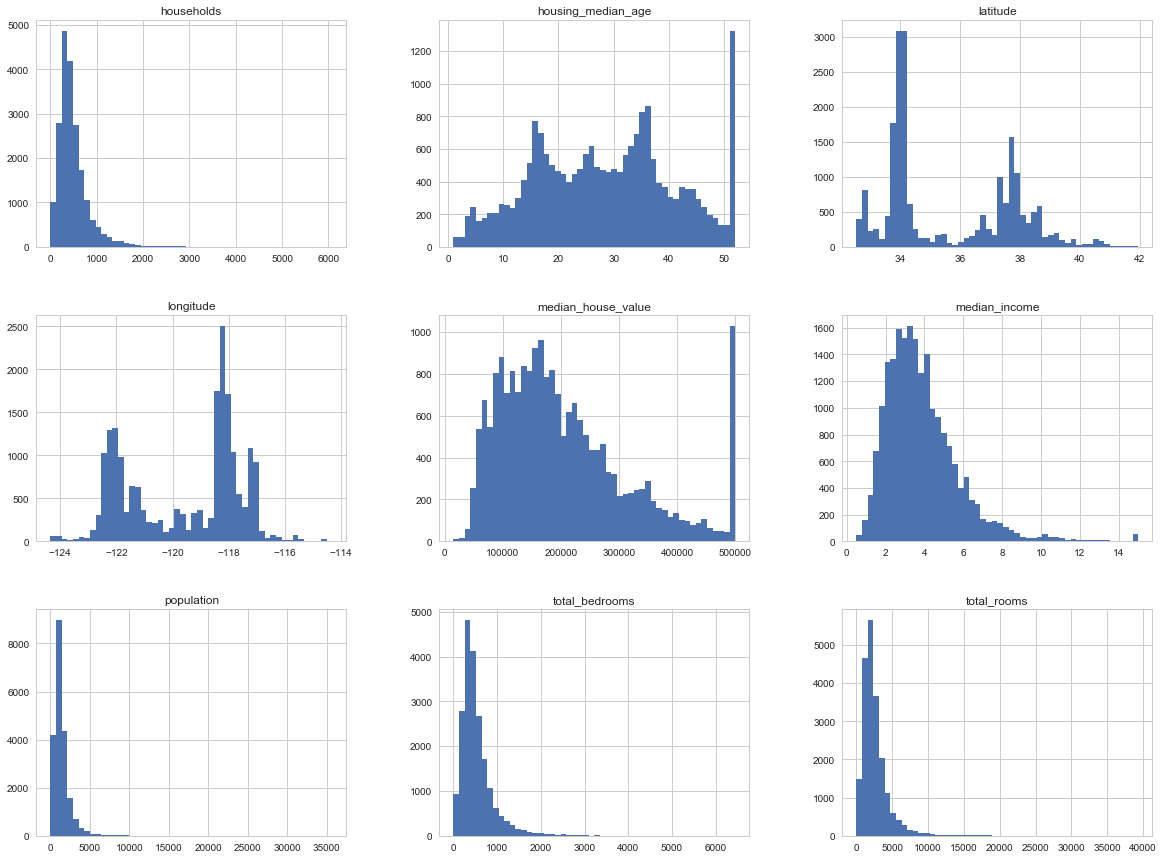

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

**Observe:**
  * median_income이 달러로 표현되어 있지 않다.  
    전처리된 데이터를 다루는 것이 문제는 되지 않지만, **어떻게 계산된 것인지 반드시 이해하고 있어야 한다.**
  * Target Value로 사용되는 중간 주택 가격이 최댓값이 한정되어 있다. 
    사용자와 검토 후,  
    1) 한곗값 밖의 범위에 대한 정확한 레이블을 구할지?  
    2) 훈련세트에서 이런 구역을 제거하던지?
  * 특성들의 **스케일**을 조정
  * **데이터의 분포**가 Fat Tail은 일부 머신러닝 알고리즘에서 패턴을 찾기 어렵게 만든다. (정규분포에 가깝도록 변형이 필요)

## 1.3 Test Set 만들기

Traing Set과 Test Set을 구분할 때는  
Data Snooping Bias(데이터 스누핑 편향)를 조심해야 한다.

* Data Snooping : Data를 미리 보게 된다면 그 Data에 맞춰서 과대적합하는 현상

### 1.3.1 무작위 샘플링

In [23]:
import numpy as np

def split_train_set(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [24]:
train_set, test_set = split_train_set(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


**Note:**  
* 다음번에 업데이트 된 데이터셋을 사용할 때는 문제가 발생

### 1.3.2 식별자 이용한 샘플링 (해시 값)

In [25]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

### 1.3.2 식별자 이용한 샘플링 (Index 값)

In [27]:
housing_with_id = housing.reset_index() #index 열이 추가된 데이터프레임이 반환
train_set1, test_set1 = split_train_test_by_id(housing_with_id, 0.2, "index")

In [28]:
print(len(train_set1), "train +", len(test_set1), "test")

16512 train + 4128 test


**Note:**  
* 행의 인덱스를 고유 식별자로 사용할 때  
  1. 새 데이터는 데이터셋의 끝에 추가
  2. 어떤 행도 삭제되지 않아야 한다.

### 1.3.2 식별자 이용한 샘플링 (특정 고유값 생성)

In [29]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set2, test_set2 = split_train_test_by_id(housing_with_id, 0.2, "id")

In [30]:
print(len(train_set2), "train +", len(test_set2), "test")

16322 train + 4318 test


### 1.3.3 사이킷런 활용

In [6]:
from sklearn.model_selection import train_test_split

train_set3, test_set3 = train_test_split(housing, test_size=0.2, random_state=42)

In [7]:
print(len(train_set3), "train +", len(test_set3), "test")

16512 train + 4128 test


**Note:**  
* train_test_split 특징  
  1. 난수 초기값을 지정할 수 있는 random_state을 매개변수로 가지고 있음
  2. 행의 갯수가 같은 여러개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나룰 수 있다

In [19]:
# 2번째 특징 실습 (index로 넘기기)
train_index = train_set3.index

train_set4 = housing.loc[train_index]

In [25]:
train_set3.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [26]:
train_set4.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


### 1.3.4 계층적 샘플링 (stratified sampling)

샘플링은 전체를 대표할 수 있도록 선택하기 위해 노력해야 한다.  
그래서 데이터셋의 특정 비율을 반영되도록 샘플링 하는 것을 계층적 샘플링이라 한다.

(미국 전체 인구의 51.3% 여성이고, 48.7% 남성)

1,000명을 샘플링한다고 했을 때, 무작위 샘플링을 사용하면   
49%적거나, 54%보다 많은 여성이 테스트 세트에 들어갈 확률이 12%이다.

In [32]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

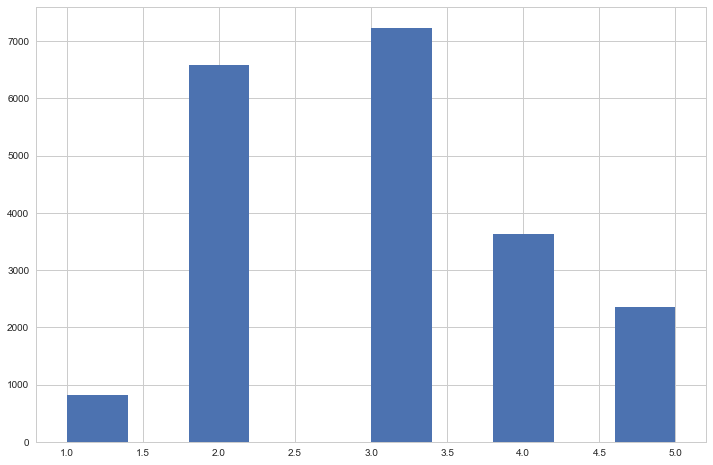

In [33]:
housing["income_cat"].hist(figsize=(12,8))
plt.show()

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [35]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [36]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [49]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [50]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


**Observe:**
* 계층 샘플링이 랜덤 샘플링보다 오류율이 더 적게 나며, 전체데이터 분포와 비슷한 비율로 샘플링 됨을 볼 수 있다.

**Summary:**
* Test set을 나누는 중요한 원칙은 모델이 Test set을 미리 보지 않는 것이다. (Overfitting 방지)  
  Random_state을 설정하고 특정값을 이용하여 샘플링 하는 것이 다 그러한 이유이다.  
* 계층 샘플링을 활용하면 전체 데이터와 비슷한 분포로 Test set을 샘플링 할 수 있다.

## 2. EDA

### 2.1 지리정보 시각화

In [37]:
train = strat_train_set.copy()

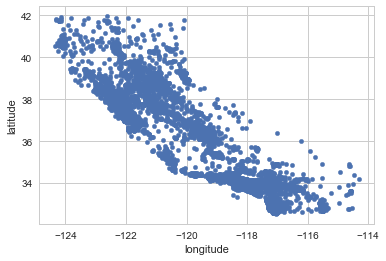

In [38]:
train.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

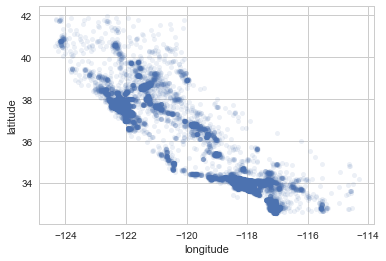

In [39]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

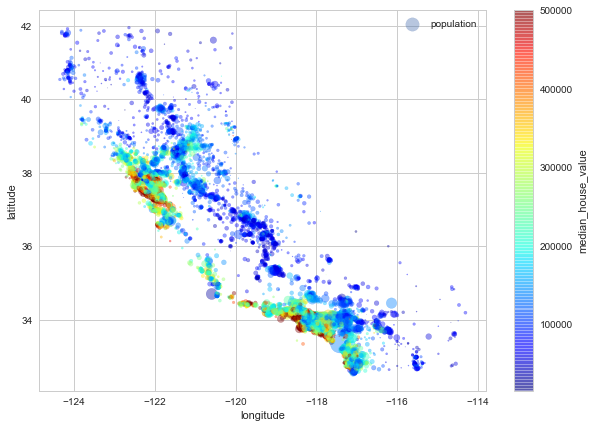

In [40]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
          s=train["population"]/100, label="population", figsize=(10,7),
          c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.show()

**Observe:**
* 인구는 원의 반지름으로, 주택가격은 색깔로 표현 (푸른색 -> 붉은색)  
* 해안가가 가격이 높아 보이나, 위도35도 위쪽 지역은 대게 주택가격이 높지 않아서 규칙이 적용되기가 어렵다.

### 2.2 상관관계

In [41]:
corr_matrix = train.corr()

In [42]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

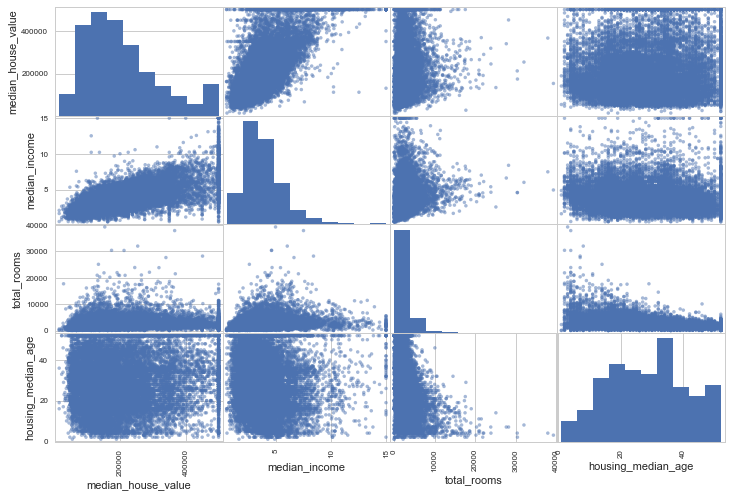

In [43]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train[attributes], figsize=(12,8))
plt.show()

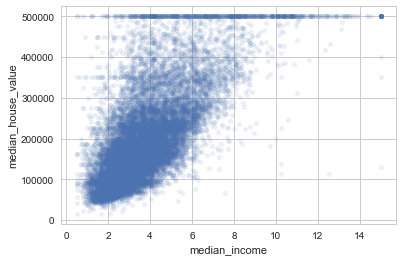

In [44]:
train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

**Observe:**
* 주택가격과 소득 간에 강한 상관관계를 보임  
* 가격제한 값인 500,000에서 수평선으로 보임  
  450,000, 350,000 그리고 280,000에서도 수편선이 보임  
  (이런 이상한 형태는 학습하지 않도록 해당 구역을 제거하는 것이 좋다.)

In [45]:
train["rooms_per_household"] = train["total_rooms"] / train["households"]
train["bedrooms_per_room"] = train["total_bedrooms"] / train["total_rooms"]
train["population_per_household"]= train["population"] / train["households"]

In [46]:
corr_matrix = train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [47]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [48]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

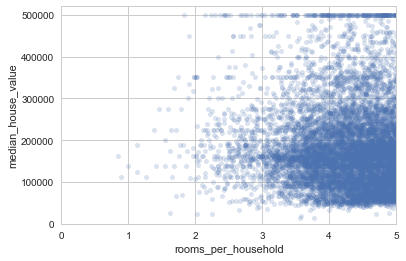

In [49]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## 2.5 Prepare the data for Machine Learning algorithms

In [50]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [51]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2.571135,NaN,2.254446,2.0
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,6.371389,NaN,4.178817,4.0
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,5.064767,NaN,2.588083,4.0
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,5.511509,NaN,2.657289,2.0
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,4.866192,NaN,2.468327,3.0


### 2.5.1 Null값 처리 방법 (4가지)

In [52]:
# Option 1 - dropna() : 해당 데이터만 제거
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat


In [53]:
# Option 2 - drop() : 해당 특성을 제거
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2.571135,NaN,2.254446,2.0
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,6.371389,NaN,4.178817,4.0
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,5.064767,NaN,2.588083,4.0
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,5.511509,NaN,2.657289,2.0
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,4.866192,NaN,2.468327,3.0


In [54]:
# Option 3 - fillna() : 어떤 값으로 채움
sample_incomplete_rows["total_bedrooms"].fillna(housing["total_bedrooms"].median(), inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2.571135,NaN,2.254446,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,6.371389,NaN,4.178817,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,5.064767,NaN,2.588083,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,5.511509,NaN,2.657289,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,4.866192,NaN,2.468327,3.0


#### Imputer

In [56]:
# Option 4 - Imputer (수치형 특성에는 imputer 사용을 권장)
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [57]:
# 중앙값은 수치형 데이터에만 적용 가능하기에 수치형 데이터만 따로 복사본 생성
housing_num = housing.drop('ocean_proximity', axis=1)

#housing_num = housing.select_dtypes(include=[np.number])

In [58]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [59]:
# 각 특성의 중간값을 계산해서 그 결과를 statistics_속석에 저장
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        5.23228423e+00,  2.03031374e-01,  2.81765270e+00,  3.00000000e+00])

In [60]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        5.23228423e+00,  2.03031374e-01,  2.81765270e+00,  3.00000000e+00])

In [62]:
X = imputer.transform(housing_num)

In [63]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index = list(housing.index.values))

In [64]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,2.571135,0.203031,2.254446,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,6.371389,0.203031,4.178817,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,5.064767,0.203031,2.588083,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,5.511509,0.203031,2.657289,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,4.866192,0.203031,2.468327,3.0


In [66]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,4.625369,0.223852,2.094395,2.0
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,6.008850,0.159057,2.707965,5.0
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.225108,0.241291,2.025974,2.0
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,5.232295,0.200866,4.135977,2.0
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,4.505810,0.231341,3.047847,3.0


### 2.5.2 범주형 특성 다루기

In [95]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [97]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

**Note:**
* Pandas의 factorize()를 통해 카테고리를 정수값으로 매핑(1차원 배열)    
  이렇게 하면 가까이 있는 두 값이 더 비슷하다고 생각
* 이 문제를 해결하기 위해서는 OneHotEncoder 활용하여 이진특성을 만들어 해결  
  범주형 값을 원-핫 벡터로 변경

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [98]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [99]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

**Note:**
* fit_transform() 메서드는 2차원 배열을 넣어줘야 함. factorize는 1차원배열  
  그래서 2차원으로 구조 변경해야 함   
  .reshape(-1, 1) : -1은 해당 차원의 크기는 전체 배열에서 다른 차원이 정해지고 남은 크기
* One-Hot Encoder는 희소행렬을 출력함 (1의 위치만 기억)  
  넘파이 배열로 바꾸려면 toarray() 메서드 호출하면 가능

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [111]:
# from sklearn.preprocessing import CategoricalEncoder

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [112]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [113]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### 2.5.3 나만의 변환기

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [103]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,0.223852,2.0944,2,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,0.159057,2.70796,5,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,0.241291,2.02597,2,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,0.200866,4.13598,2,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,0.231341,3.04785,3,4.50581,3.04785


### 2.5.5 Pipeline

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [105]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

**Note:**
* 수치형 컬럼을 넘파이 배열로 추출 (사이킷런이 판다스의 데이터프레임을 다룰 수 없음)

In [115]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [116]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [117]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [118]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [119]:
housing_prepared.shape

(16512, 20)

## 2.6 모델 선택과 훈련

In [120]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67787.52086008864

In [122]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49131.07873062015

**Observe:**
* RMSE를 측정해본 결과, 중간주택가격이 120,000~265,000사이인데 예측오차가 67,787인것은 좋지 못함 (과소적합)  
* 과소적합을 해결하기 위해서는 3가지 선택 사항
  1. 더 좋은 모델을 선택
  2. 더 좋은 특성을 만들어 낸다
  3. 모델의 규제를 감소한다.

In [123]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [124]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**Observe:**
* 오차가 0??? : 과대적합된 상태, 데이터의 일부를 활용하여 검증에 사용해야 함

### 2.6.2 교차검증

In [125]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_score = np.sqrt(-scores)

In [127]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(tree_rmse_score)

점수: [70931.45751735 66420.62550272 69916.10695532 70478.81144304
 69808.95853328 75581.76116149 69371.69789769 71140.48025727
 75980.63128608 70916.65625754]
평균: 71054.71868117934
표준편차: 2688.6379619521053


#### 선형회귀 모델 스코어

In [129]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [66137.25628937 66432.60992217 67328.19947659 73956.26527856
 67764.70817974 70780.70296982 63816.42902074 67368.31226793
 70292.26404556 67289.91170757]
평균: 68116.66591580624
표준편차: 2704.9305916111766


In [134]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68116.667389
std       2851.242724
min      63816.430055
25%      66646.936809
50%      67348.255872
75%      69660.381210
max      73956.248692
dtype: float64

**Note:**
* pd.Series로 받아서 describe() 매서드를 통해 Score에 대한 통계치 확인 가능

#### 랜덤포레스트

In [131]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [132]:
# 훈련 세트에 대한 점수
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21922.727387907995

In [133]:
# 검증 세트에 대한 점수
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51270.86454407 48886.70220645 53173.38702174 54759.66426319
 50928.06055525 56599.41805389 51935.89168721 49873.79106637
 55582.73722194 53464.51404617]
평균: 52647.50306662878
표준편차: 2383.9804048181954


**Observe:**
* 훈련세트에 대한 (rmse)점수가 21,922인데,  
  검증세트에 대한 (rmse)점수는 52,647로 훈련세트에 비해 훨씬 높다. 이 모델도 훈련세트에 과대적합
* 과대적합을 해결하는 방법
  1. 모델을 간단히
  2. 모델에 규제를 가함
  3. 더 많은 훈련 데이터를 모음

In [136]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

106512.58423876738

## 2.7 모델 세부 튜닝

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv= 5, scoring='neg_mean_squared_error',
                          return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [139]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [140]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다

In [141]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65770.99094372915 {'max_features': 2, 'n_estimators': 3}
57118.139424881156 {'max_features': 2, 'n_estimators': 10}
54476.344295530485 {'max_features': 2, 'n_estimators': 30}
61816.825217529666 {'max_features': 4, 'n_estimators': 3}
54678.597179709395 {'max_features': 4, 'n_estimators': 10}
52593.94541997569 {'max_features': 4, 'n_estimators': 30}
61128.85275594905 {'max_features': 6, 'n_estimators': 3}
53841.62520339982 {'max_features': 6, 'n_estimators': 10}
52226.48118014986 {'max_features': 6, 'n_estimators': 30}
61137.45040535039 {'max_features': 8, 'n_estimators': 3}
54101.21822548606 {'max_features': 8, 'n_estimators': 10}
51806.88805462561 {'max_features': 8, 'n_estimators': 30}
63949.79943872004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56239.52862539414 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61806.60693080987 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54928.407794037936 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [142]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.085485,0.005071,-4.325823e+09,-1.164251e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-4.181150e+09,...,-4.427363e+09,-1.132163e+09,-4.147107e+09,-1.188713e+09,-4.348009e+09,-1.166563e+09,0.004074,0.000407,1.439005e+08,1.980010e+07
1,0.270288,0.012232,-3.262482e+09,-6.061418e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.091047e+09,...,-3.420218e+09,-5.870723e+08,-3.094636e+09,-6.298447e+08,-3.353599e+09,-6.081309e+08,0.011794,0.000716,1.406600e+08,1.398165e+07
2,0.814604,0.039044,-2.967672e+09,-4.552863e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",7,-2.771666e+09,...,-3.124670e+09,-4.502200e+08,-2.811861e+09,-4.670866e+08,-3.044879e+09,-4.520866e+08,0.011473,0.010251,1.463873e+08,6.898228e+06
3,0.136051,0.004150,-3.821320e+09,-1.035364e+09,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.626034e+09,...,-3.940891e+09,-1.020832e+09,-3.533050e+09,-1.059043e+09,-3.994597e+09,-1.035169e+09,0.010441,0.000534,2.009610e+08,1.419179e+07
4,0.500926,0.013622,-2.989749e+09,-5.497643e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.836200e+09,...,-3.081295e+09,-5.356408e+08,-2.800171e+09,-5.641464e+08,-3.118999e+09,-5.486376e+08,0.064868,0.001962,1.411170e+08,9.092663e+06
5,1.409907,0.033134,-2.766123e+09,-4.233603e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.596531e+09,...,-2.946179e+09,-4.199578e+08,-2.546898e+09,-4.308700e+08,-2.871378e+09,-4.233485e+08,0.061901,0.004380,1.618849e+08,4.276536e+06
6,0.185934,0.004565,-3.736737e+09,-9.898245e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",13,-3.740715e+09,...,-3.903542e+09,-9.328448e+08,-3.489986e+09,-1.026033e+09,-3.745823e+09,-1.013505e+09,0.002508,0.000694,1.365784e+08,3.346362e+07
7,0.612425,0.012373,-2.898921e+09,-5.408935e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",5,-2.814754e+09,...,-3.099780e+09,-5.155018e+08,-2.717172e+09,-5.787478e+08,-2.920908e+09,-5.395086e+08,0.018620,0.002991,1.286803e+08,2.074617e+07
8,1.789001,0.028195,-2.727605e+09,-4.152028e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.628102e+09,...,-2.904337e+09,-4.038635e+08,-2.538233e+09,-4.351692e+08,-2.809927e+09,-4.170908e+08,0.005772,0.002007,1.301210e+08,1.095275e+07
9,0.229651,0.003695,-3.737788e+09,-9.912376e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",14,-3.574537e+09,...,-3.889905e+09,-9.439071e+08,-3.560605e+09,-1.002573e+09,-3.826655e+09,-9.980373e+08,0.002288,0.000102,1.406945e+08,2.973638e+07


In [143]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ebc0278>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ebc0470>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [144]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50943.01882123752 {'max_features': 7, 'n_estimators': 180}
53280.356409884815 {'max_features': 5, 'n_estimators': 15}
52700.301457603426 {'max_features': 3, 'n_estimators': 72}
52756.438826287216 {'max_features': 5, 'n_estimators': 21}
51118.98636947805 {'max_features': 7, 'n_estimators': 122}
52656.377226297285 {'max_features': 3, 'n_estimators': 75}
52651.36240803972 {'max_features': 3, 'n_estimators': 88}
51658.84528726877 {'max_features': 5, 'n_estimators': 100}
52353.40676543853 {'max_features': 3, 'n_estimators': 150}
66175.24356580873 {'max_features': 5, 'n_estimators': 2}


In [145]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.42631545e-02, 4.87734179e-02, 4.22253087e-02, 1.38036176e-02,
       1.42750554e-02, 1.30925624e-02, 1.33368930e-02, 2.83478671e-01,
       2.87506143e-02, 3.29282976e-02, 6.81793128e-02, 1.30371143e-01,
       2.17203757e-02, 6.03312892e-02, 2.56608537e-02, 6.14757802e-03,
       1.37148073e-01, 1.05908421e-04, 1.95145522e-03, 3.45641839e-03])

#### Feature Importance Naming

In [150]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.28347867062228804, 'median_income'),
 (0.13714807312256433, 'INLAND'),
 (0.1303711434770183, 'income_cat'),
 (0.06817931283010963, 'population_per_household'),
 (0.060331289239054356, 'pop_per_hhold'),
 (0.054263154530140884, 'longitude'),
 (0.04877341788837137, 'latitude'),
 (0.04222530865132019, 'housing_median_age'),
 (0.032928297550874036, 'bedrooms_per_room'),
 (0.028750614265902034, 'rooms_per_household'),
 (0.025660853695667316, 'bedrooms_per_room'),
 (0.021720375684160072, 'rooms_per_hhold'),
 (0.014275055445918705, 'total_bedrooms'),
 (0.013803617552115491, 'total_rooms'),
 (0.013336893005678497, 'households'),
 (0.013092562387850174, 'population'),
 (0.006147578020370076, '<1H OCEAN'),
 (0.0034564183875240707, 'NEAR OCEAN'),
 (0.0019514552217018727, 'NEAR BAY'),
 (0.0001059084213706368, 'ISLAND')]

### 2.7.5 Final Model

In [146]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [147]:
final_rmse

49680.68179209355

In [148]:
from scipy import stats

In [149]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([47678.00627247, 51605.69740384])

In [151]:
# t-score
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(47678.006272472696, 51605.69740383871)

In [152]:
# z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(47678.605944922536, 51605.14336578583)

## joblib을 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## RandomizedSearchCV을 위한 Scipy 분포 함수

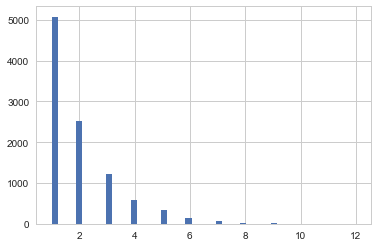

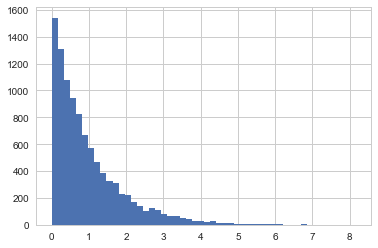

In [153]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()